In [1]:
%%capture
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [2]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [3]:
filename = r"../input/summary-vietnamese/data_summary.csv"
df = pd.read_csv(filename).drop('Unnamed: 0',1)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102681


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Summary,Text
98537,"Hòn đảo xanh mướt bị cô lập giữa mây trời, bi...","Stóra Dímun là một trong 18 đảo nhỏ, thuộc q..."
40469,Sau khi cựu quản lý Facebook kêu gọi nghị sĩ M...,Trong cuộc điều trần trước Tiểu ban Bảo vệ Ngư...
15870,"Tỉ lệ mắc bệnh đái tháo đường, thường được gọi...","Theo PGS TS Tạ Văn Bình, tỉ lệ mắc bệnh tiểu đ..."
81708,"Sau phản ánh của một số cơ quan báo chí, UBND...","Theo đó, UBND TPHCM đã yêu cầu chính quyền quậ..."
4926,"Ông Bùi Tín, nhà bất đồng chính kiến có tiếng,...",Trong một cuộc thảo luận tại trụ sở BBC ở Lond...


In [4]:
'''Loại bỏ các giá trị trùng lặp và giá trị rỗng'''

df.drop_duplicates(subset=['Text'],inplace=True) #dropping duplicates
df.dropna(axis=0,inplace=True) #dropping na
df = df.reset_index().drop('index', axis = 1)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 96284


,Summary,Text
0,Ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,Tổng thống Mỹ Donald Trump và Tổng thống Pháp ...
1,"Rời khỏi Việt Nam vào 10/2016, ông Vũ Đình Duy...",Vũ Đình Duy hồi tháng 5 xuất hiện trước tòa tạ...
2,Thủ tướng Iraq xác nhận với BBC rằng Syria khô...,Ông Maliki xác nhận các vụ không kích của Syri...
3,Người Việt Nam biết rất ít về ông Trump nhưng ...,Tiến sỹ Vũ Cao Phan tin rằng nếu được tiến hàn...
4,Bốn khoa học gia người Mỹ từng đoạt giải Nobel...,GS Jack Steinberger trao đổi với GS Lê Kim Ngọ...


# Data preparation

In [5]:
def cleanWord(s):
    miss = ['!','@','#','$','%','^','&','*','(',')','-','–','_','+','=','{','[','}',']','|',':',';','?','/','<','>','~','`','‘','’',',','()','“','"', '...','”', '“”','\\', '>>', '>>>']
    for i in miss:
        s = s.replace(i,'')
    return re.sub(r'\'', '', s)

def remove_link(string):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', string)

def remove_extra_whitespace(string):
    text = re.sub(r'\s+', ' ', string).strip()
    return text

def lower_word(data):
    return data.lower()

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [alphabet for alphabet in word if alphabet not in string.punctuation]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)


# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_number_from_text(text)
    text = rm_punc_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

def solve(string):
    func = [lower_word, remove_link, remove_extra_whitespace, cleanWord, clean_text]
    for i in func:
        string = i(string)
    return string

In [6]:
df.Text = df.Text.apply(lambda x: solve(str(x)))
df.Summary = df.Summary.apply(lambda x: solve(str(x)))
df.sample(5)

,Summary,Text
88056,ngày tỉnh lào cai và tỉnh lai châu đã họp bàn ...,ngày lãnh đạo tỉnh lào cai và tỉnh lai châu đã...
52728,doanh nghiệp của nữ đại gia kim tiền số việt n...,ctcp vàng bạc đá quý phú nhuận pnj của bà cao ...
92819,cronaldo khẳng định anh gia nhập man utd không...,man utd đang phải trải qua một mùa giải đáng t...
20336,nga cáo buộc anh phát minh ra một câu chuyện b...,ông vasily nebenzia đại sứ của nga tại liên hi...
51424,la gi đang dần thay da đổi thịt để hoàn thiện ...,đẩy nhanh các công trình trọng điểm nằm cách t...


Finding what should be the **maximum length** of **Text** and **Summary** that will be feed or accepted by the learning algorithm

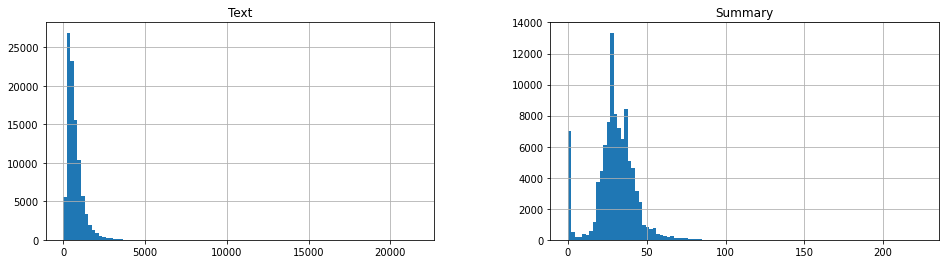

In [7]:
text_count = [len(sentence.split()) for sentence in df.Text]
summary_count = [len(sentence.split()) for sentence in df.Summary]

pd.DataFrame({'Text': text_count, 'Summary': summary_count}).hist(bins=100, figsize=(16, 4))
plt.show()

In [8]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of summary have 0-60 words
print(get_word_percent(df.Summary, 60))

# Check how many % of text have 0-300 words
print(get_word_percent(df.Text, 300))

0.99
0.15


In [9]:
max_text_len = 300
max_summary_len = 60

In [10]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['Text'])
    cleaned_summary = np.array(df['Summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'Text': short_text, 'Summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 14664


,Text,Summary
6507,gia đình em gái nghệ sĩ cho biết sức khỏe ông ...,hà nội
10878,trở thành người thắng cuộc golfer trẻ nguyễn a...,giải golf tournament chính thức khép lại sau n...
4448,tuần này là tuần đau thương với các tỷ phú toà...,musk người giàu nhất thế giới mất tỷ usd tuần ...
13670,thông tin ban đầu trước đó rạng sáng ngày chị ...,ngày cơ quan chức năng tp yên bái tỉnh yên bái...
2359,theo hiệp hội chế biến và xuất khẩu thuỷ sản v...,tháng xuất khẩu cá ngừ sang thị trường trung q...


In [11]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g') 

In [12]:
def read_content(string):
    original = rdrsegmenter.tokenize(string)
    original = ' '.join([' '.join(x) for x in original])

    return original

In [13]:
df.Text = df.Text.apply(lambda x: read_content(str(x)))
df.Summary = df.Summary.apply(lambda x: read_content(str(x)))
df.head(5)

,Text,Summary
0,ông maliki xác_nhận các vụ không_kích của syri...,thủ_tướng iraq xác_nhận với bbc rằng syria khô...
1,lý quang diệu được cho là người đứng đằng sau...,chính_phủ singapore cho_hay cựu thủ_tướng ngườ...
2,ông hà kim ngọc thứ_trưởng bộ ngoại_giao phát_...,kết_thúc phiên kiểm_định định_kỳ phổ_quát về t...
3,hai bàn thắng của luis suarez hiệp một tạo lợi...,hlv manchester city manuel pellegrini tin rằng...
4,thủ_hiến tiểu_bang nam úc ông jay weatherill l...,một chính_khách gốc việt từng là dân tỵ nạn ...


In [14]:
df.Summary = df.Summary.apply(lambda x: f'_START_ {x} _END_')
start_token = 'sostok'
end_token = 'eostok'
df.Summary  = df.Summary.apply(lambda x: f'{start_token} {x} {end_token}')

# Training build_vocab with 2 method of skipgam and CBOW

In [15]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [16]:
def labelize_text_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [17]:
all_x = pd.concat([df.Text,df.Summary])
all_x_w2v = labelize_text_ug(all_x, 'all')

In [18]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, vector_size=150, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 29328/29328 [00:00<00:00, 1099987.91it/s]


In [19]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 29328/29328 [00:00<00:00, 1039616.54it/s]


CPU times: user 5min 11s, sys: 1.44 s, total: 5min 13s
Wall time: 1min 26s


In [20]:
model_ug_sg = Word2Vec(sg=1, vector_size=150, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 29328/29328 [00:00<00:00, 1107195.68it/s]


In [21]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 29328/29328 [00:00<00:00, 1108892.44it/s]


CPU times: user 11min 19s, sys: 1.99 s, total: 11min 21s
Wall time: 2min 59s


**Save results**

In [22]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [23]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

**Appending cbow and sg for better result**

In [24]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 31125 word vectors.


# Tokenizing

In [25]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [26]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['Text']),
    np.array(df['Summary']),
    test_size=0.15,
    random_state=1,
    shuffle=True
)

## **Tokenizing Text x**

In [27]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.2, 'total_coverage': 1.07, 'count': 19710, 'total_count': 30230}


In [28]:
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])

In [29]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [30]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

x_vocab_size = len(x_tokenizer.word_index) + 1

print(x_vocab_size)

30231


## **Tokenizing Summary y**

In [32]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 70.87, 'total_coverage': 3.12, 'count': 6919, 'total_count': 9763}


In [33]:
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])

In [34]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [35]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

y_vocab_size = len(y_tokenizer.word_index) + 1

print(y_vocab_size)

9764


# Modelling

In [37]:
latent_dim = 240
embedding_dim = 300
num_epochs = 15

In [38]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Converted 18031 words (12199 misses)
Converted 8769 words (994 misses)


In [39]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(30231, 300)
(9764, 300)


In [40]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [41]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():
        # =====================
        # Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [42]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [43]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

# **Running Model**

In [44]:
def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('Model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

In [45]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [46]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [47]:
def seq2highlights(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

In [48]:
model_func = build_seq2seq_model_with_just_lstm
inference_func = build_seq2seq_model_with_just_lstm_inference
decode_sequence_func = decode_sequence_seq2seq_model_with_just_lstm

In [49]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

2022-05-13 09:01:04.439517: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     9069300     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 240), ( 519360      embedding[0][0]                  
______________________________________________________________________________________________

In [50]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [51]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128, 
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

2022-05-13 09:01:06.111451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
98/98 [==============================] - 906s 9s/step - loss: 3.5483 - accuracy: 0.5500 - val_loss: 2.8761 - val_accuracy: 0.5862
Epoch 2/15
98/98 [==============================] - 878s 9s/step - loss: 2.8536 - accuracy: 0.5894 - val_loss: 2.6034 - val_accuracy: 0.6163
Epoch 3/15
98/98 [==============================] - 887s 9s/step - loss: 2.6201 - accuracy: 0.6119 - val_loss: 2.4279 - val_accuracy: 0.6320
Epoch 4/15
98/98 [==============================] - 883s 9s/step - loss: 2.4667 - accuracy: 0.6256 - val_loss: 2.3211 - val_accuracy: 0.6422
Epoch 5/15
98/98 [==============================] - 887s 9s/step - loss: 2.3604 - accuracy: 0.6348 - val_loss: 2.2446 - val_accuracy: 0.6488
Epoch 6/15
98/98 [==============================] - 879s 9s/step - loss: 2.2799 - accuracy: 0.6411 - val_loss: 2.1894 - val_accuracy: 0.6542
Epoch 7/15
98/98 [==============================] - 886s 9s/step - loss: 2.2173 - accuracy: 0.6465 - val_loss: 2.1478 - val_accuracy: 0.6577
Epoch 8/15
98

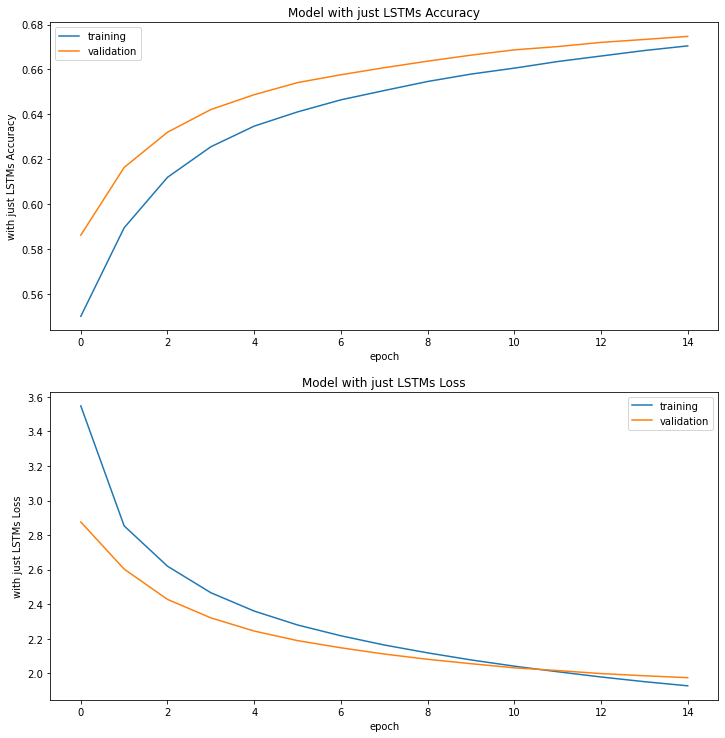

In [52]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'with just LSTMs Accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'with just LSTMs Loss', 212)

In [53]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [54]:
reference = []
hypothesis = []
# Testing on training data
for i in range(0, 15):
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

for i in range(0, 100):
    reference.append(seq2summary(y_train_padded[i]))
    hypothesis.append(decode_sequence_seq2seq_model_with_just_lstm(x_train_padded[i].reshape(1, max_text_len), encoder_model,decoder_model))

Original summary:  start hà nội không chỉ đón chào gần phóng viên quốc tế mà còn chứng kiến sự xuất hiện của một đội ngũ người săn tin mới các bác xe ôm end 
Predicted summary:   start một người đàn ông đã bị bắt giữ một con cá voi quý hiếm hoi khi đang chới với một con cá voi biển quý hiếm end

Original summary:  start nhà lãnh đạo bắc hàn ông kim jongun đã gửi một thông điệp cá nhân hiếm hoi chúc mừng chủ tịch trung quốc tập cận bình end 
Predicted summary:   start tổng thống mỹ donald trump đã có quyết định xử phạt hành vi phạm quy định về việc làm việc tại việt nam end

Original summary:  start tháng đầu năm campuchia xuất sang việt nam tấn xoài tươi chiếm tổng lượng xoài xuất khẩu của quốc gia này end 
Predicted summary:   start các nhà nghiên cứu phát triển khai thác nước ngoài nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài khơi nước ngoài kh

# Calculating Rouge Scores

In [55]:
! pip install rouge

In [56]:
from rouge import Rouge

In [57]:
score = Rouge()
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'r': 0.18289051665490497,
  'p': 0.30732711079860064,
  'f': 0.20387932575348766},
 'rouge-2': {'r': 0.03233100577189024,
  'p': 0.04868511048585081,
  'f': 0.03642072167369328},
 'rouge-l': {'r': 0.175851516717744,
  'p': 0.2962145584730451,
  'f': 0.19541347374186252}}